In [1]:
import numpy as np
import sys,os
sys.path.append(os.getcwd()[:-11]+'src/')
from models import *
from topological_methods import *
import matplotlib.pyplot as plt
clrs = plt.cm.tab20.colors

In [2]:
#Plots for normal initialization
mean = 0
std = 0.1
n_perms = 500
out_dims = [1,2,3,4,5,10,25,50,100]#,500,1000]
in_dims = [*np.arange(1,7),10,25,50,100]

#eval points
res = 100
lims = 5

region_ranks = np.zeros([len(in_dims),len(out_dims),n_perms])
for m, dim_in in enumerate(in_dims):
    for n, dim_out in enumerate(out_dims):
        for l in range(n_perms):
            x = torch.Tensor(lims*2*(np.random.rand(dim_in, res)-0.5)).T
            rand_model = FeedforwardNetwork(input_size=dim_in,hidden_sizes=[dim_in+dim_out],mean=mean,std=std, init_type='normal')
            out = rand_model(x)
            out_code = [torch.sum(out[i]>0,axis=1) for i in range(len(out))]
            region_ranks[m,n,l] = sum(out_code[0]<dim_in).item()>0

In [3]:
#Plots for linear scaling with index(R)
n_neurons = 200
inpt_dim = 10
R_indxs = np.arange(1,n_neurons,10)#[0,2,3,5,10,50,100,500]
region_min_code = np.zeros([len(R_indxs),n_perms])
for r, r_indx in enumerate(R_indxs):
    for l in range(n_perms):
        x = torch.Tensor(lims*2*(np.random.rand(dim_in, res)-0.5)).T
        rand_model = FeedforwardNetwork(input_size=dim_in,hidden_sizes=[n_neurons])
        R = torch.eye(n_neurons)
        rand_inds = np.random.choice(np.arange(0,n_neurons),size=r_indx, replace=False)
        R[rand_inds,rand_inds] = -1
        rand_model.layers[0].weight = torch.nn.Parameter(R@rand_model.layers[0].weight)
        out = rand_model(x)
        out_code = [torch.sum(out[i]>0,axis=1) for i in range(len(out))]
        region_min_code[r,l] = torch.min(out_code[0]).item()
theory_curve = np.concatenate([np.arange(0,int(n_neurons/2)), int(n_neurons/2)-np.arange(0,int(n_neurons/2))])

In [4]:
#studying the number of low rank regions as a function of the mean of a distribution and the number of output neurons
means = np.linspace(-0.2,0.2,40)
in_dim = 3

region_ranks_mean = np.zeros([len(out_dims),len(means),n_perms])

for d, dim in enumerate(out_dims):
    for m, mean in enumerate(means):
        for n in range(n_perms):
            x = torch.Tensor(lims*2*(np.random.rand(in_dim, res)-0.5)).T
            rand_model = FeedforwardNetwork(input_size=in_dim,hidden_sizes=[dim],mean=mean,std=std, init_type='normal')
            out = rand_model(x)
            out_code = [torch.sum(out[i]>0,axis=1) for i in range(len(out))]
            region_ranks_mean[d,m, n] = sum(out_code[0]<in_dim).item()>0
#min(*[sum(out_code[i]<in_dim).item()>0 for i in range(len(out))])#sum(out_code<in_dim).item()/res#

In [5]:
depth = 5
R_indxs_2 = np.arange(0,int(n_neurons/2),50)
region_ranks_depth = np.zeros([depth,len(R_indxs_2),n_perms])

for r, r_indx in enumerate(R_indxs_2):
    print(r)
    for n in range(n_perms):
        x = torch.Tensor(lims*2*(np.random.rand(in_dim, res)-0.5)).T
        rand_model = FeedforwardNetwork(input_size=in_dim,hidden_sizes=[n_neurons for k in range(depth)])
        for layer in rand_model.layers:
            if isinstance(layer, nn.Linear):
                R = torch.eye(n_neurons)
                rand_inds = np.random.choice(np.arange(0,n_neurons),size=r_indx, replace=False)
                R[rand_inds,rand_inds] = -1
                layer.weight = torch.nn.Parameter(R@layer.weight)
        out = rand_model(x)
        out_code = [torch.sum(out[i]>0,axis=1) for i in range(len(out))]
        region_ranks_depth[:,r,n] = np.array([min(*[torch.min(out_code[j]).item() for j in range(depth)]) 
                                              for i in range(depth)])


0
1


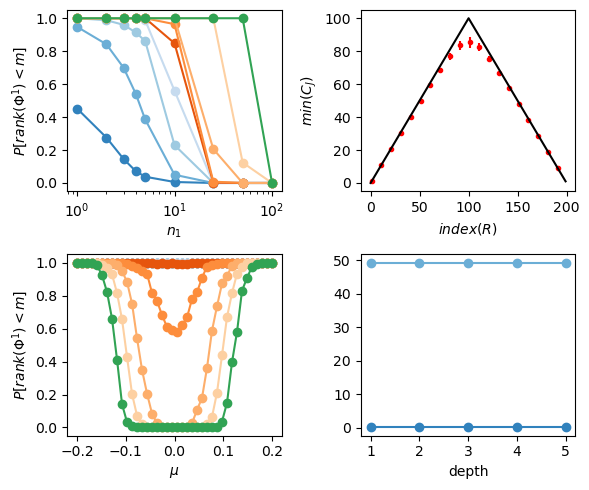

In [6]:
clrs = plt.cm.tab20c.colors

fig, ax = plt.subplots(2,2,figsize=(6,5))

for k in range(len(out_dims)):
    ax[0,0].plot(out_dims, np.mean(region_ranks,2)[k],'-o',color=clrs[k])
ax[0,0].set_xlabel('$n_1$')
ax[0,0].set_xscale('log')
ax[0,0].set_ylabel('$P[rank(\Phi^1)<m]$')

ax[0,1].plot(R_indxs, np.mean(region_min_code,1),'.',color='red')
ax[0,1].errorbar(R_indxs, np.mean(region_min_code,1),yerr=1*np.std(region_min_code,1),color='red', fmt='none',markersize=12)
ax[0,1].plot(theory_curve,'k')
ax[0,1].set_xlabel('$index(R)$')
#ax[0,1].set_xscale('log')
ax[0,1].set_ylabel('$min(C_{J})$')
#ax[0,1].set_yscale('log')
#ax[0,0].legend(in_dims)

for k in range(len(out_dims)):
    ax[1,0].plot(means,np.mean(region_ranks_mean[k],1),'-o',color=clrs[k],)

ax[1,0].set_xlabel('$\mu$')
ax[1,0].set_ylabel('$P[rank(\Phi^1)<m]$')

for k in range(len(R_indxs_2)):
    ax[1,1].plot(np.arange(1,depth+1), np.mean(region_ranks_depth[:,k],1),'-o',color=clrs[k])
ax[1,1].set_xlabel('depth')
fig.tight_layout()

In [7]:
#plot of defining network polynomial
x = torch.Tensor(2*2*(np.random.rand(2, 1000)-0.5)).T

rand_net = FeedforwardNetwork(input_size=2,hidden_sizes=[25],mean=mean,std=std) 
nn.init.normal_(rand_net.layers[0].weight, mean=mean, std=std)

polyn = torch.prod(rand_net.layers[0].weight@x.T+rand_net.layers[0].bias[:,None],axis=0)
polyn[abs(polyn)>10] = np.nan

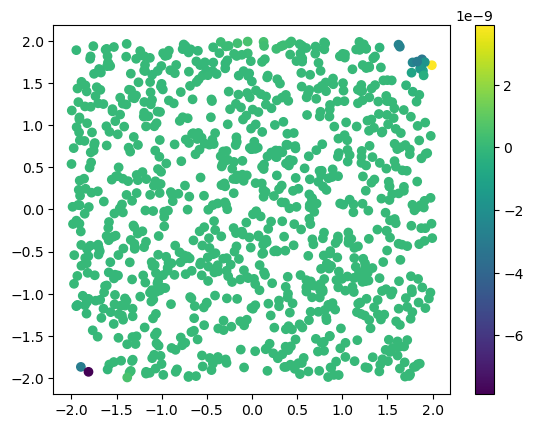

In [8]:
xy = x.detach().numpy().T
plt.scatter(xy[0],xy[1],c=polyn.detach())
plt.colorbar()